In [2]:
# Compares ARPS model output with observed PIPS DSDs
# TODO: Update this code to allow to read in multiple ARPS patches
# Use pyCRMtools arps_read interface instead of DataHandler interface
# Longer term: decide which interface to develop and use going forward.

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import pytz as pytz
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
from pyCRMtools.pycaps import arps_read
from pyCRMtools.pycaps import pycaps_fields
from pyCRMtools.pycaps import calvars_radar as radar
import pandas as pd
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Function definitions
def plotDSD(Dl, Dmid, Dr, ND, ax=None):
    """Plots a DSD on a semilog plot"""
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    ax.bar(Dl, ND, Dr-Dl, 10.**2., align='edge', log=True, color='tan', edgecolor = 'k')
    ax.set_yscale('log')
    ax.set_ylim(10.**2., 10.**8.5)
    ax.set_xlim(0., 9.)
    ax.set_xlabel('D (mm)')
    ax.set_ylabel(r'N(D) $(m^{-4})$')
    
    return ax

def plotVD(Dl, Dmid, Vl, countsMatrix, Vt_fit, ax=None, strongwindflag=False):
    """Plot drop counts in each velocity/diameter bin for a given DSD"""
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    countsplot = ma.masked_where(countsMatrix <= 0, countsMatrix)

    C = ax.pcolor(Dl, Vl, countsplot, vmin=1, vmax=50, edgecolors='w')
    ax.plot(Dmid, Vt_fit, c='r')
    # ax1.scatter(X[0:10,20:31],Y[0:10,20:31],c='r',marker='x')
    fig.colorbar(C)

    if(strongwindflag):
        ax.text(0.5, 0.5, 'Flagged for strong wind contamination!',
                 horizontalalignment='center',
                 verticalalignment='center', color='y',
                 transform=ax.transAxes)
#     if(plot_strongwindQC):
#         ax1.scatter(X[strongwindmask], Y[strongwindmask], c='r', marker='x', alpha=1.0)
#     if(plot_splashingQC):
#         ax1.scatter(X[splashmask], Y[splashmask], c='w', marker='o', alpha=0.75)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(splashmask,mask=-splashmask),cmap=cm.Reds,alpha=0.1)
#     if(plot_marginQC):
#         ax1.scatter(X[marginmask], Y[marginmask], c='g', marker='x', alpha=0.1)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(marginmask,mask=-marginmask),cmap=cm.Reds,alpha=0.1)
#     if(plot_rainfallspeedQC):
#         ax1.scatter(X[fallspeedmask], Y[fallspeedmask], c='k', marker='x', alpha=0.5)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(fallspeedmask,mask=-fallspeedmask),cmap=cm.gray,alpha=0.1)
#     if(plot_rainonlyQC):
#         ax1.scatter(X[rainonlymask], Y[rainonlymask], c='g', marker='x', alpha=0.5)

    ax.set_xlim(0.0, 9.0)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.set_xlabel('D (mm)')
    ax.set_ylim(0.0, 15.0)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.set_ylabel(r'V$_T$ (m s$^{-1}$)')

In [80]:
# Set some global parameters
rhoa = 1.0 # kg m^-3
cr = 1000.*np.pi/6.

sampling_area = dis.sensor_area
sampling_width = dis.sensor_width
sampling_length = dis.sensor_length

# Model stuff

# From desired start and end times (UTC) get a range of datetimes and corresponding range of times in
# seconds since model start
timestamp_model_start = '20160331180000'  # Start time of model corresponding to 0 s
datetime_model_start = datetime.strptime(timestamp_model_start, '%Y%m%d%H%M%S')

timestamp_start = '20160331220000'  # Start time of desired time window
timestamp_stop = '20160331234000'  # Stop time of desired time window
datetime_start = datetime.strptime(timestamp_start, '%Y%m%d%H%M%S')
datetime_stop = datetime.strptime(timestamp_stop, '%Y%m%d%H%M%S')
tintv = 60.  # Interval in seconds for model output

datetime_range = CRMutils.get_datetime_range(datetime_start, datetime_stop, tintv)
trange = CRMutils.modeltimes_from_datetimes(datetime_range, datetime_start=datetime_model_start)

#basedir = '/Volumes/scr_fast/Projects/VORTEXSE/simulations/ARPS/2016_IOP3/3DVAR/1km0331163DVARCA00005min180_3km030015min540'
fileformat = 'hdf'
basedir = '/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN001/'
runname = 'ena001'
runlabel = '1km453x453'
trailer = ''

DSD_interval = 60.
DSD_interval_td = timedelta(seconds=DSD_interval)
D = dis.avg_diameter / 1000.
Dl = dis.min_diameter / 1000.
Dr = dis.max_diameter / 1000.

Dedges = np.append(Dl, Dr[-1])
Vtr = dis.assignfallspeed(dis.avg_diameter)

In [29]:
# pyPIPS input file
pyPIPS_input = '/Users/dawson29/pyPIPS_work/VORTEXSE/2016/IOP3.txt'
ib = utils.readpyPIPSinput(pyPIPS_input)
if (not os.path.exists(ib.image_dir)):
    os.makedirs(ib.image_dir)

requested elevation angle 0.5


In [30]:
# Get PIPS locations
for index, dis_name, dis_filename, dloc in \
        zip(range(0, ib.numdis), ib.dis_name_list, ib.dis_list, ib.dlocs):

    if(np.int(dloc[0]) == -1):
        filepath = os.path.join(ib.dis_dir, dis_filename)
        GPS_lats, GPS_lons, GPS_stats, GPS_alts, dloc = dis.readPIPSloc(
            filepath)
        ib.dlocs[index] = dloc

    print("Lat/Lon/alt of " + dis_name + ": " + str(dloc)) 

Lat/Lon/alt of PIPS_1A: (35.046499999999995, -87.67749219783126, 254.11713832319492)
Lat/Lon/alt of PIPS_1B: (35.084130703422055, -87.7198528728348, 275.80548162230673)
Lat/Lon/alt of PIPS_2A: (35.015666666666675, -87.67168627067865, 226.55306760453303)
Lat/Lon/alt of PIPS_2B: (35.1515, -87.74416666666664, 325.88117263843645)


In [53]:
# Read in PIPS conventional data

datetimes_PIPS = []
T_PIPS = []
Td_PIPS = []

for dis_filename in ib.dis_list:
    #starttime = '201703251808' # '201703251800'
    #stoptime = '201703251808' # '201703251800'
    
    dis_filepath = os.path.join(ib.dis_dir, dis_filename)
    (datetimesUTC, windspds, winddirabss, fasttemps, dewpoints, pressures,
        GPS_lats, GPS_lons, GPS_stats, GPS_alts) = dis.readPIPSstation(dis_filepath, starttimestamp=timestamp_start,
                                                                       stoptimestamp=timestamp_stop)

    # datetimesUTC,pdatetimesUTC,flaggedtimes,hailflag,intensities,preciptots,reflectivities,pcounts,pcounts2, \
    #            sensortemps,concentrations,onedrop_concentrations,countsMatrix,amplitudes,windspds,winddirrels,winddirabss, \
    #         winddiags,fasttemps,slowtemps,dewpoints,RHs_derived,RHs,pressures,compass_dirs,    \
    #         GPS_lats,GPS_lons,GPS_stats,GPS_alts,voltages,DSD_interval,DSD_intervalstr,DSD_index = \
    #         dis.readPIPS(disfilepath,basicqc=True,rainfallqc=True,rainonlyqc=True,
    #         strongwindqc=True,DSD_interval=60.0)

    # Convert to numpy arrays
    windspds = np.array(windspds)
    winddirabss = np.array(winddirabss)
    fasttemps = np.array(fasttemps)
    dewpoints = np.array(dewpoints)
    pressures = np.array(pressures)
    
    # Calculate wind meteogram
    windavgintv = 60
    windgustintv = 3
    
    # Compute wind speed and direction, and wind gusts
    windspdsavg, windspdsavgvec, winddirsavgvec, windgusts, windgustsavg = dis.avgwind(winddirabss,
            windspds, windavgintv, gusts=True, gustintv=windgustintv, center=False)
#     offset = 0
#     windspdsavg,windspdsavgvec,winddirsavgvec,winddirsunitavgvec,windgusts,windgustsavg,usavg,vsavg,unit_usavg,unit_vsavg = \
#     dis.resamplewind(datetimesUTC,offset,winddirabss,windspds,'60S',gusts=True,gustintvstr='3S',center=False)
    
    # Compute potential temperature, water vapor mixing ratio, and density
    # pt = thermo.caltheta(pressures*100.,slowtemps+273.15)
    # qv = thermo.calqv(RHs/100.,pressures*100.,slowtemps+273.15)
    # rho=thermo.calrho(pressures*100.,pt,qv)

    # Determine start and end times/indices for analysis

    # datetimesUTCnums = date2num(datetimesUTC)
    
    T_PIPS.append(fasttemps)
    Td_PIPS.append(dewpoints)
    datetimes_PIPS.append(datetimesUTC)
    
    
    
    

310316 221203
2016-03-31 22:12:00
2016 3 31 22 12 0
2016-03-31 22:12:03 2016-03-31 22:12:00
GPS Offset 0:00:03
[21.1  21.11 21.12 ... 17.12 17.12 17.12]
310316 220133
2016-03-31 22:01:30
2016 3 31 22 1 30
2016-03-31 22:01:33 2016-03-31 22:01:30
GPS Offset 0:00:03
[20.62 20.62 20.63 ... 17.33 17.33 17.34]
310316 222503
2016-03-31 22:25:00
2016 3 31 22 25 0
2016-03-31 22:25:03 2016-03-31 22:25:00
GPS Offset 0:00:03
[21.13 21.11 21.11 ... 17.26 17.26 17.26]
310316 220003
2016-03-31 22:00:00
2016 3 31 22 0 0
2016-03-31 22:00:03 2016-03-31 22:00:00
GPS Offset 0:00:03
[19.58 19.57 19.57 ... 16.49 16.49 16.48]


In [59]:
# Load the ARPS grid
modelname = 'ARPS'
microphys = 'ZVD'

nproc_x = 15
nproc_y = 6

# Tell the arps_read module what the processor numbers are.
# Yes, I know this is a bad way to do this through globals. I'll fix it eventually.
arps_read.nproc_x = nproc_x
arps_read.nproc_y = nproc_y

# jindex = 192
# slc = (Ellipsis, slice(None), jindex, slice(None))
# jend = 1



# Get file path for grdbas file (note that call to read_grid handles the reading of the individual patches)
# If the grdbas file doesn't exist, fall back to a history file

grdbas_path = arps_read.get_file_path(basedir, runname, fileformat, filetype='grdbas')

patch_x = 1
patch_y = 1
grdbas_path_test = arps_read.add_patch_number(grdbas_path, patch_x, patch_y)

if not os.path.exists(grdbas_path_test):
    print("grdbas file doesn't exist, trying a history file!")
    grdbas_path = arps_read.get_file_path(basedir, runname, fileformat, time=tstart, filetype='history')
    grdbas_path_test = arps_read.add_patch_number(grdbas_path, patch_x, patch_y)
    print(os.path.exists(grdbas_path_test))

# Read in grid information
grid_dict = arps_read.readarpsgrid(grdbas_path)
print(grid_dict.keys())


# Get map projection information and create a Basemap instance
# TODO: convert to use cartopy!

ctrlat, ctrlon, trulat1, trulat2, trulon = arps_read.readarpsmap(grdbas_path)

dx = grid_dict['dx']
dy = grid_dict['dy']
nx = grid_dict['nx']
ny = grid_dict['ny']

mapwidth = nx * dx
mapheight = ny * dy

bgmap = Basemap(projection='lcc', width=mapwidth, height=mapheight, lat_1=trulat1,
                lat_2=trulat2, lat_0=ctrlat, lon_0=ctrlon, resolution='h',
                area_thresh=10., suppress_ticks=False)

# dh = getDataHandler(modelname, basedir, trange, microphys, nproc_x=15, nproc_y=6)
# dh.setRun(runname)
# xc, yc, zc, zc1d, xe, ye, ze, ze1d, bgmap = dh.loadGrid()

dict_keys(['nx', 'ny', 'nz', 'dx', 'dy', 'dz', 'x', 'y', 'z', 'zp', 'xs', 'ys', 'zs', 'zpagl', 'zsagl'])


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [60]:
xc = grid_dict['xs']
yc = grid_dict['ys']

# Find coordinates of PIPS stations in the model
print(dx, dy) 
# coord_list = []
coord_array = np.empty((len(ib.dlocs), 2))
for i, dloc in enumerate(ib.dlocs):
    xloc, yloc = bgmap(dloc[1], dloc[0])
    print(xloc, yloc) 
    iloc = (xloc-xc[1])/dx
    jloc = (yloc-yc[1])/dy
    coord_array[i, ...] = np.array([iloc, jloc])
    # coord_list.append(coords)
    
print(coord_array) 
print(coord_array.shape) 
print(coord_array[0]) 
coord_array = coord_array.T

1000.0 1000.0
226728.2543262902 253900.98552587978
222874.8015411067 258084.80521031027
227256.91376130987 250473.53498544852
220667.8426462494 265574.924876145
[[226.22825433 253.40098553]
 [222.37480154 257.58480521]
 [226.75691376 249.97353499]
 [220.16784265 265.07492488]]
(4, 2)
[226.22825433 253.40098553]


In [81]:
# Read in potential temperature, pressure, and water vapor specific humidity from a series of arps files 
# and interpolate them to the PIPS locations, building up a time series.
print(coord_array)
print(coord_array[0, :])

T_model = []
Td_model = []
pte_model = []

# Find bounds of subarray that converts all the PIPS locations
# This is just to save time in reading the ARPS files since only those patches that overlap these bounds
# will be read in. Right now, read_hdfvars returns the full domain array, but all values outside of those covered
# by the patches are set to zero.

ibgn = np.floor(np.min(coord_array[0, :]))
iend = np.ceil(np.max(coord_array[0, :]))
jbgn = np.floor(np.min(coord_array[1, :]))
jend = np.ceil(np.max(coord_array[1, :]))

print(ibgn, iend, jbgn, jend)

for time in trange:
    print("Loading time ", time) 
    filepath = arps_read.get_file_path(basedir, runname, fileformat, time=time, filetype='history')
    
    vardict = arps_read.read_hdfvars(filepath, ['p', 'pt', 'qv'], ibgn=ibgn, jbgn=jbgn, iend=iend, jend=jend)
    
    p = vardict['p']
    pt = vardict['pt']
    qv = vardict['qv']
    
    p_atPIPS = ndimage.map_coordinates(p[..., 1], coord_array, order=1)
    pt_atPIPS = ndimage.map_coordinates(pt[..., 1], coord_array, order=1)
    qv_atPIPS = ndimage.map_coordinates(qv[..., 1], coord_array, order=1)
    
#     print p_atPIPS
#     print pt_atPIPS
#     print qv_atPIPS
    
    T_atPIPS = thermo.calT(p_atPIPS, pt_atPIPS)-273.15
    Td_atPIPS = thermo.calTd(p_atPIPS, qv_atPIPS)-273.15
    pte_atPIPS = thermo.calpte(p_atPIPS, pt_atPIPS, qv_atPIPS)
    
    #print T_atPIPS
    
    T_model.append(T_atPIPS)
    Td_model.append(Td_atPIPS)
    pte_model.append(pte_atPIPS)

[[226.22825433 222.37480154 226.75691376 220.16784265]
 [253.40098553 257.58480521 249.97353499 265.07492488]]
[226.22825433 222.37480154 226.75691376 220.16784265]
220.0 227.0 249.0 266.0
Loading time  14400.0
Loading time  14460.0
Loading time  14520.0
Loading time  14580.0
Loading time  14640.0
Loading time  14700.0
Loading time  14760.0
Loading time  14820.0
Loading time  14880.0
Loading time  14940.0
Loading time  15000.0
Loading time  15060.0
Loading time  15120.0
Loading time  15180.0
Loading time  15240.0
Loading time  15300.0
Loading time  15360.0
Loading time  15420.0
Loading time  15480.0
Loading time  15540.0
Loading time  15600.0
Loading time  15660.0
Loading time  15720.0
Loading time  15780.0
Loading time  15840.0
Loading time  15900.0
Loading time  15960.0
Loading time  16020.0
Loading time  16080.0
Loading time  16140.0
Loading time  16200.0
Loading time  16260.0
Loading time  16320.0
Loading time  16380.0
Loading time  16440.0
Loading time  16500.0
Loading time  16560

In [82]:
npzfilename = runname+'_T_Td_pte_ts.npz'
savevars = {}
savevars['T'] = T_model
savevars['Td'] = Td_model
savevars['pte'] = pte_model
np.savez(npzfilename, **savevars)

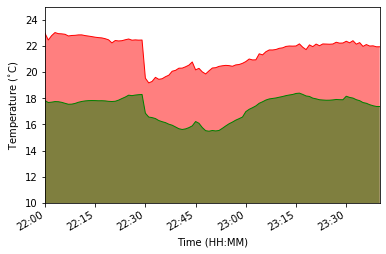

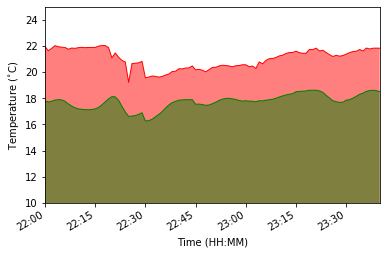

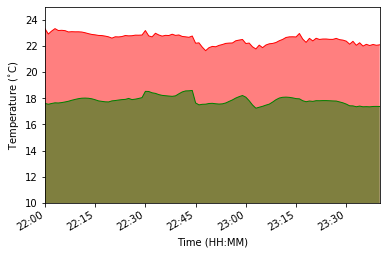

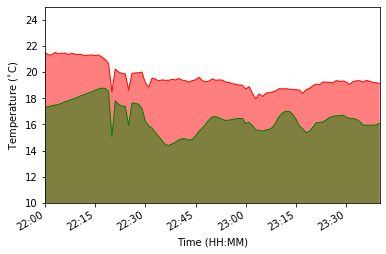

In [83]:
dateformat = '%H:%M' 
formatter = dates.DateFormatter(dateformat)
locator = dates.MinuteLocator(byminute=[0,15,30,45])
minorlocator = None
timelabel = 'Time (HH:MM)'
plottimes = dates.date2num(datetime_range)
xaxislimits = [plottimes[0], plottimes[-1]]
meteo_T_Td_range = [10., 25.]

T_model = np.array(T_model)
Td_model = np.array(Td_model)

for i, PIPSname in enumerate(ib.dis_name_list):
    #print i
    fig, ax = plt.subplots()
    fields = [T_model[:, i], Td_model[:, i]]
    fieldparamdicts = [PIPSplot.temp_params, PIPSplot.dewpoint_params]
    ax = PIPSplot.plotmeteogram(ax, [plottimes], fields, fieldparamdicts)
    axparamdict1 = {'majorxlocator': locator, 'majorxformatter': formatter,
                    'minorxlocator': minorlocator, 'axeslimits': [xaxislimits, meteo_T_Td_range],
                    'axeslabels': [timelabel, r'Temperature ($^{\circ}$C)']}
    axparamdicts = [axparamdict1]
    ax, = PIPSplot.set_meteogram_axes([ax], axparamdicts)
    #ax.plot(trange, T_model[:, i], color = 'r')
    #ax.set_xlim(tstart, tstop)
    #ax.set_ylim(15.0, 30.0)

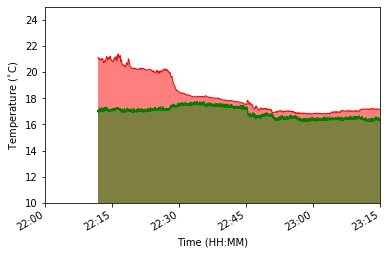

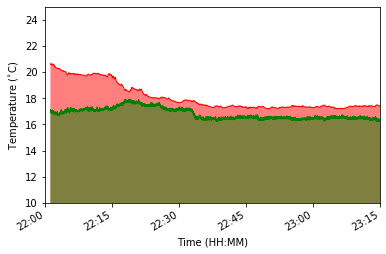

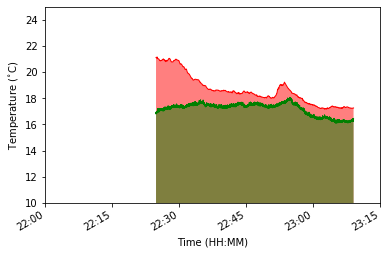

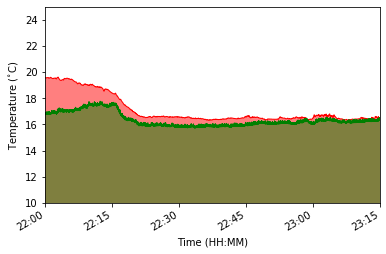

In [57]:
dateformat = '%H:%M' 
formatter = dates.DateFormatter(dateformat)
locator = dates.MinuteLocator(byminute=[0,15,30,45])
minorlocator = None
timelabel = 'Time (HH:MM)'
xaxislimits = [dates.date2num(datetime_range[0]), dates.date2num(datetime_range[-1])]
meteo_T_Td_range = [10., 25.]

for i, PIPSname in enumerate(ib.dis_name_list):
    plottimes = dates.date2num(datetimes_PIPS[i])
    #print i
    fig, ax = plt.subplots()
    fields = [T_PIPS[i], Td_PIPS[i]]
    fieldparamdicts = [PIPSplot.temp_params, PIPSplot.dewpoint_params]
    ax = PIPSplot.plotmeteogram(ax, [plottimes], fields, fieldparamdicts)
    axparamdict1 = {'majorxlocator': locator, 'majorxformatter': formatter,
                    'minorxlocator': minorlocator, 'axeslimits': [xaxislimits, meteo_T_Td_range],
                    'axeslabels': [timelabel, r'Temperature ($^{\circ}$C)']}
    axparamdicts = [axparamdict1]
    ax, = PIPSplot.set_meteogram_axes([ax], axparamdicts)
    #ax.plot(trange, T_model[:, i], color = 'r')
    #ax.set_xlim(tstart, tstop)
    #ax.set_ylim(15.0, 30.0)

In [94]:
from pyCRMtools.modules import dualpara as dualpol

# Now read rain DSD information
rhor = 1000.
cr = np.pi / 6. * rhor
mu = 1. / 3.

qr_model = []
nr_model = []
zr_model = []
N0r_model = []
lamdar_model = []
alphar_model = []
vardict = {}


for time in trange:
    print("Loading time ", time) 
    filepath = arps_read.get_file_path(basedir, runname, fileformat, time=time, filetype='history')
    print(filepath)
    
    
    vardict = pycaps_fields.get_fields(vardict, field_names=['rho', 'qr', 'nr', 'zr'], path_grdbas=grdbas_path, 
                                       path_hdf=filepath, ibgn=ibgn, jbgn=jbgn, iend=iend, jend=jend, 
                                       multipatch=True, grid_dict=grid_dict, ignore_existing_vars=True)
    
#     vardict = arps_read.read_hdfvars(filepath, ['rho', 'qr', 'nr', 'zr'], ibgn=ibgn, jbgn=jbgn, iend=iend, 
#                                      jend=jend)
    
    rhoa = vardict['rho']
    qr = vardict['qr']
    nr = vardict['nr']
    zr = vardict['zr']
    
    rhoa_atPIPS = ndimage.map_coordinates(rhoa[..., 1], coord_array, order=1)
    qr_atPIPS = ndimage.map_coordinates(qr[..., 1], coord_array, order=1)
    nr_atPIPS = ndimage.map_coordinates(nr[..., 1], coord_array, order=1)
    zr_atPIPS = ndimage.map_coordinates(zr[..., 1], coord_array, order=1)
        
    print(rhoa_atPIPS)

    # Calculate shape, slope, and intercept parameters of gamma distribution
    # assume mu = 1./3., rhor = 1000.
    rhor = 1000.
    # Shape parameter
    # alphar_atPIPS = dualpol.solve_alpha_iter(rhoa_atPIPS, mu, qr_atPIPS, nr_atPIPS, zr_atPIPS, rhor)
    alphar_atPIPS = dsd.solve_alpha(rhoa_atPIPS, cr, qr_atPIPS, nr_atPIPS, zr_atPIPS)
    # Intercept parameter
    N0r_atPIPS, _ = dsd.cal_N0(rhoa_atPIPS, qr_atPIPS, nr_atPIPS, cr, alphar_atPIPS)
    # Slope parameter
    lamdar_atPIPS = dsd.cal_lamda(rhoa_atPIPS, qr_atPIPS, nr_atPIPS, cr, alphar_atPIPS)
        
    N0r_model.append(N0r_atPIPS)
    lamdar_model.append(lamdar_atPIPS)
    alphar_model.append(alphar_atPIPS)

Loading time  14400.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN001/ena001.hdf014400
field names (before):  ['rho', 'qr', 'nr', 'zr']
field names (after):  ['rho', 'qr', 'nr', 'zr']
needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys([])
needed variables (after):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.1360222 1.1354798 1.1360822 1.133896 ]
Loading time  14460.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN001/ena001.hdf014460
field names (before):  ['rho', 'qr', 'nr', 'zr']
field names (after):  ['rho', 'qr', 'nr', 'zr']
needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys(['rho', 'qr', 'nr', 'zr'])
needed v

retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.1363846 1.1359695 1.1368365 1.1357015]
Loading time  15240.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN001/ena001.hdf015240
field names (before):  ['rho', 'qr', 'nr', 'zr']
field names (after):  ['rho', 'qr', 'nr', 'zr']
needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys(['rho', 'qr', 'nr', 'zr'])
needed variables (after):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.1363958 1.1357917 1.1368982 1.135561 ]
Loading time  15300.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN001/ena001.hdf015300
field names (before):  ['rho', 'qr', 'nr', 'zr']
field names (after):  ['rho', 'qr', 'nr', 'zr']
needed_variables (before):

/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:75: RuntimeWarning: invalid value encountered in true_divide
  lamda = ((gamma4 / gamma1) * cx * Ntx / (rhoa * q))**(1.0 / 3.0)
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:123: RuntimeWarning: invalid value encountered in greater_equal
  N0 = np.where(lamda >= 0.0, N0, 0.0)
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:124: RuntimeWarning: invalid value encountered in greater_equal
  N0_norm = np.where(lamda >= 0.0, N0_norm, 0.0)


needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys(['rho', 'qr', 'nr', 'zr'])
needed variables (after):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.1370677 1.1356156 1.1378503 1.1356306]
Loading time  15480.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN001/ena001.hdf015480
field names (before):  ['rho', 'qr', 'nr', 'zr']
field names (after):  ['rho', 'qr', 'nr', 'zr']
needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys(['rho', 'qr', 'nr', 'zr'])
needed variables (after):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.1370544 1.1356037 1.1378113 1.1360466]
Loading time  15540.0
/Users/dawson29/sshfs_mounts/rice_scr

/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:240: RuntimeWarning: divide by zero encountered in true_divide
  tmp1 = cx / (rhoa * q)
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:241: RuntimeWarning: invalid value encountered in multiply
  g = tmp1 * Z * tmp1 * Ntx
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:121: RuntimeWarning: divide by zero encountered in true_divide
  alpha) * gamma4 * (128.0 / 3.0) / \
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:121: RuntimeWarning: invalid value encountered in multiply
  alpha) * gamma4 * (128.0 / 3.0) / \


needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys(['rho', 'qr', 'nr', 'zr'])
needed variables (after):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.1372037 1.1392272 1.1374099 1.1396631]
Loading time  15780.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN001/ena001.hdf015780
field names (before):  ['rho', 'qr', 'nr', 'zr']
field names (after):  ['rho', 'qr', 'nr', 'zr']
needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys(['rho', 'qr', 'nr', 'zr'])
needed variables (after):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.1375122 1.1407857 1.1375828 1.1404264]
Loading time  15840.0
/Users/dawson29/sshfs_mounts/rice_scr

needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys(['rho', 'qr', 'nr', 'zr'])
needed variables (after):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.1492088 1.1442628 1.1364595 1.1435175]
Loading time  16620.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN001/ena001.hdf016620
field names (before):  ['rho', 'qr', 'nr', 'zr']
field names (after):  ['rho', 'qr', 'nr', 'zr']
needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys(['rho', 'qr', 'nr', 'zr'])
needed variables (after):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.1487702 1.1437705 1.136767  1.1433158]
Loading time  16680.0
/Users/dawson29/sshfs_mounts/rice_scr

needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys(['rho', 'qr', 'nr', 'zr'])
needed variables (after):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.1482615 1.142547  1.1414952 1.1438069]
Loading time  17460.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN001/ena001.hdf017460
field names (before):  ['rho', 'qr', 'nr', 'zr']
field names (after):  ['rho', 'qr', 'nr', 'zr']
needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys(['rho', 'qr', 'nr', 'zr'])
needed variables (after):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.1475089 1.1419578 1.1413006 1.1428546]
Loading time  17520.0
/Users/dawson29/sshfs_mounts/rice_scr

needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys(['rho', 'qr', 'nr', 'zr'])
needed variables (after):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.1429132 1.1416237 1.1415069 1.1489413]
Loading time  18300.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN001/ena001.hdf018300
field names (before):  ['rho', 'qr', 'nr', 'zr']
field names (after):  ['rho', 'qr', 'nr', 'zr']
needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys(['rho', 'qr', 'nr', 'zr'])
needed variables (after):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.140495  1.1391187 1.1395502 1.1466216]
Loading time  18360.0
/Users/dawson29/sshfs_mounts/rice_scr

needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys(['rho', 'qr', 'nr', 'zr'])
needed variables (after):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.136275  1.1335043 1.1356614 1.143624 ]
Loading time  19140.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN001/ena001.hdf019140
field names (before):  ['rho', 'qr', 'nr', 'zr']
field names (after):  ['rho', 'qr', 'nr', 'zr']
needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys(['rho', 'qr', 'nr', 'zr'])
needed variables (after):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.1394185 1.1355658 1.1389194 1.1431234]
Loading time  19200.0
/Users/dawson29/sshfs_mounts/rice_scr

needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys(['rho', 'qr', 'nr', 'zr'])
needed variables (after):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.1403924 1.138619  1.1417669 1.142697 ]
Loading time  19980.0
/Users/dawson29/sshfs_mounts/rice_scratch/VORTEXSE/simulations/ARPS/2016_IOP3/EnKF/1km453x453_newse/1km453x453_newse/EN001/ena001.hdf019980
field names (before):  ['rho', 'qr', 'nr', 'zr']
field names (after):  ['rho', 'qr', 'nr', 'zr']
needed_variables (before):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
existing var dict (inside retrieve_variables):  dict_keys(['rho', 'qr', 'nr', 'zr'])
needed variables (after):  {'rho', 'p', 'qr', 'nr', 'zr', 'pt', 'qv'}
retrieved fields:  dict_keys(['p', 'qr', 'nr', 'zr', 'pt', 'qv', 'rho'])
[1.138516  1.1375391 1.1393244 1.1427445]
Loading time  20040.0
/Users/dawson29/sshfs_mounts/rice_scr

(101, 32, 4)


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


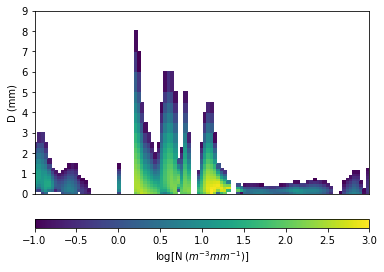

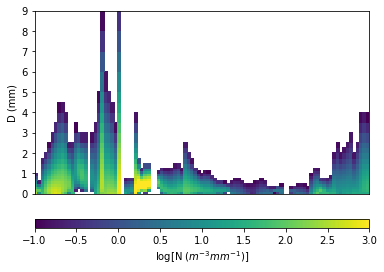

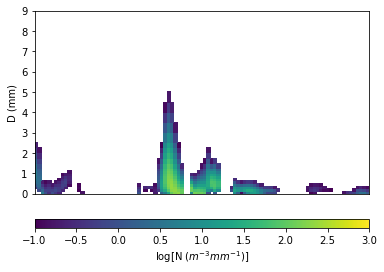

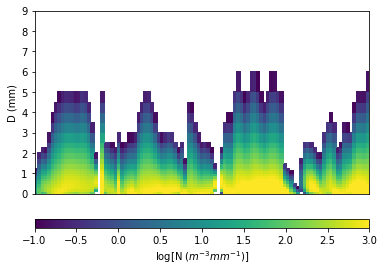

In [95]:
# Now plot the raw model DSD
cr = np.pi/6.
PSDtimestamps_edge = [x - DSD_interval_td for x in datetime_range]
# Add an extra 10 sec for the last time bin boundary
PSDtimestamps_edge.append(PSDtimestamps_edge[-1] + DSD_interval_td)
PSDstarttimes = dates.date2num(PSDtimestamps_edge)

N0r_model = np.array(N0r_model)
lamdar_model = np.array(lamdar_model)
alphar_model = np.array(alphar_model)

ND = np.empty((np.size(N0r_model, axis=0), np.size(D), np.size(N0r_model, axis=1)))

print(ND.shape) 

# # print N0r
# # print lamdar
# # print tmpalphar2

# print xeplot.shape

for index, _ in np.ndenumerate(N0r_model):
    ND[index[0], :, index[1]] = 1.e-3 * N0r_model[index] * D**alphar_model[index] * np.exp(-lamdar_model[index] * D)
ND = np.ma.masked_invalid(ND)
logND = np.log10(ND)
logND = np.ma.masked_where(logND <= -1.0, logND)

for i, PIPSname in enumerate(ib.dis_name_list):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    divider = make_axes_locatable(ax)
    C = ax.pcolor(PSDstarttimes, Dl * 1000., logND[:, :, i].swapaxes(0, 1), vmin=-1.0, vmax=3.0)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5.0))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
    #ax.set_xlim(-30.0,30.0)
    ax.set_ylim(0.0, 9.0)
    ax.set_ylabel('D (mm)')
    cax = divider.append_axes("bottom", size="5%", pad=0.35)
    cb = fig.colorbar(C, cax=cax, orientation='horizontal')
    cb.set_label(r'log[N ($m^{-3} mm^{-1}$)]')

# plt.savefig('raw_modelDSD.png',dpi=300)

In [ ]:
# Now plot the sampled model DSD
# STOPPED HERE!

Dmax = 8.
Dmax_index = np.searchsorted(Dr, Dmax/1000.)

ND_samp = np.empty((np.size(N0r_model, axis=0), np.size(D[:Dmax_index+1]), np.size(N0r_model, axis=1)))
for index, _ in np.ndenumerate(N0r_model):
    # print index,dp_data_2D['ntr'][index,0]
    positions, diameters, velocities, ND_sample = create_random_gamma_DSD(nr_model[index], lamdar[index], 
                                                                          alphar[index], Vtr, sampling_length, 
                                                                          sampling_width, Dl, D, Dr, 
                                                                          sampling_interval=60.)
    Nc_bin2[index[0],:,index[1]] = 1.e-3*ND_sample

Nc_bin2 = np.ma.masked_invalid(Nc_bin2)
logNc_bin2 = np.log10(Nc_bin2)
logNc_bin2 = np.ma.masked_where(logNc_bin2 <= -1.0,logNc_bin2)

for i, PIPSname in enumerate(ib.dis_name_list):
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(111)
    divider = make_axes_locatable(ax)
    C = ax.pcolor(PSDstarttimes,Dl[:Dmax_index+1]*1000.,logNc_bin2[:,:,i].swapaxes(0,1),vmin=-1.0,vmax=3.0)
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5.0))
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
    #ax.set_xlim(-30.0,30.0)
    axparamdict1 = {'majorxlocator': locator, 'majorxformatter': formatter,
                    'minorxlocator': minorlocator, 'axeslimits': [None, [0.0, 9.0]],
                    'axeslabels': [timelabel, r'D (mm)']}
    axparamdicts = [axparamdict1]
    ax, = PIPSplot.set_meteogram_axes([ax], axparamdicts)
#     ax.set_ylim(0.0,9.0)
#     ax.set_ylabel('D (mm)')
    cax = divider.append_axes("bottom",size="5%",pad=0.75)
    cb = fig.colorbar(C,cax=cax,orientation='horizontal')
    cb.set_label(r'log[N ($m^{-3} mm^{-1}$)]')
    plt.savefig(PIPSname+'_'+runlabel+'_sampled_model_DSD.png',dpi=300)
# plt.savefig('raw_modelDSD.png',dpi=300)